Multiclass classification with GPflow
--

*Alexander G. de G. Matthews and James Hensman, 2016*

In [2]:
from __future__ import print_function
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

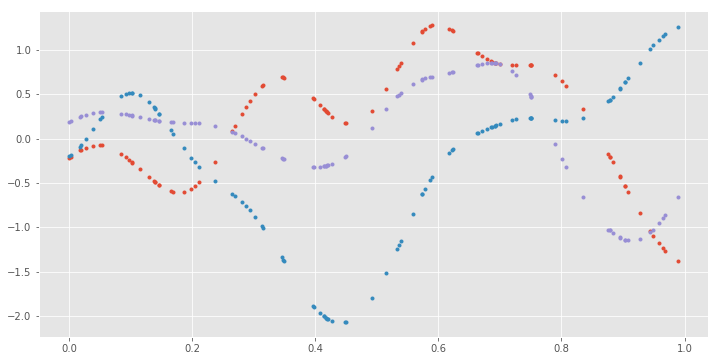

In [3]:
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,3))

plt.figure(figsize=(12,6))
plt.plot(X, f, '.')

In [4]:
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

### Sparse Variational Gaussian approximation

In [5]:
m = gpflow.models.SVGP(
    X, Y, kern=gpflow.kernels.Matern32(1) + gpflow.kernels.White(1, variance=0.01),
    likelihood=gpflow.likelihoods.MultiClass(3),
    Z=X[::5].copy(), num_latent=3, whiten=True, q_diag=True)

In [6]:
m.kern.white.variance.trainable = False
m.Z.trainable = False
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 75.774953
  Number of iterations: 182
  Number of functions evaluations: 215


In [7]:
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

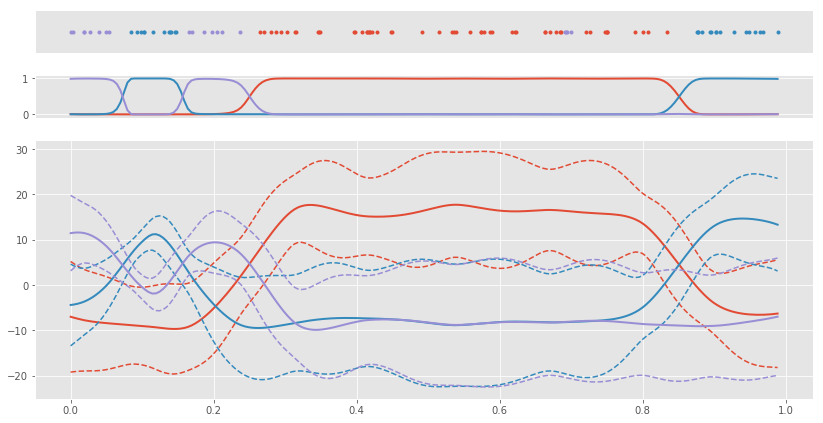

In [8]:
plot(m)

In [9]:
print(m.kern)

<Parameter name:SVGP/kern/matern32/variance [trainable] shape:() transform:+ve prior:None>
value: 80.67611841517638

<Parameter name:SVGP/kern/matern32/lengthscales [trainable] shape:() transform:+ve prior:None>
value: 0.10404520542788771

<Parameter name:SVGP/kern/white/variance shape:() transform:+ve prior:None>
value: 0.01


### Sparse MCMC

In [19]:
with gpflow.defer_build():
    m = gpflow.models.SGPMC(X, Y, 
                     kern=gpflow.kernels.Matern32(1, lengthscales=0.1) + gpflow.kernels.White(1, variance=0.01),
                     likelihood=gpflow.likelihoods.MultiClass(3),
                     Z=X[::5].copy(), num_latent=3)
    m.kern.matern32.variance.prior = gpflow.priors.Gamma(1.,1.)
    m.kern.matern32.lengthscales.prior = gpflow.priors.Gamma(2.,2.)
    m.kern.white.variance.trainables = False
    
m.compile()

In [20]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=10)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 105.594702
  Number of iterations: 11
  Number of functions evaluations: 14


In [21]:
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=500, epsilon=0.04, lmax=15) # verbose=True

AttributeError: 'SGPMC' object has no attribute 'set_state'

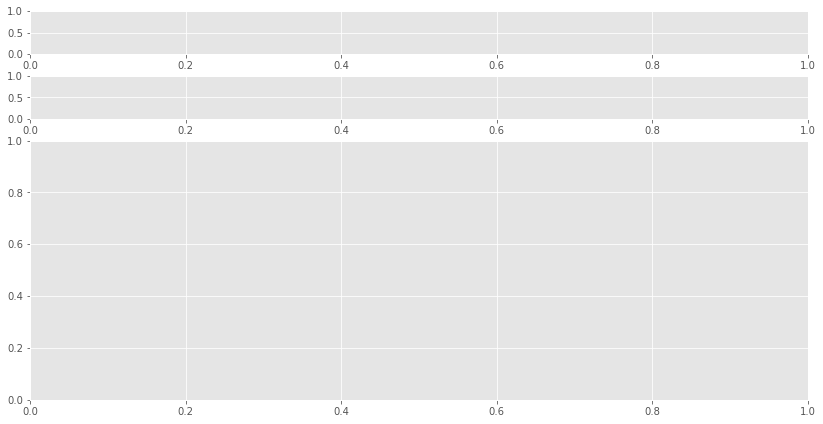

In [22]:
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []
    for s in samples[100::10]: # burn 100, thin 10
        m.set_state(s)
        Ypred.append(m.predict_y(xx)[0])
        Fpred.append(m.predict_f_samples(xx, 1).squeeze())

    for i in range(m.likelihood.num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)
        for Y in Ypred:
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

plot_from_samples(m, samples)

In [ ]:
df = m.get_samples_df(samples)

In [ ]:
df.head()

In [ ]:
_ = plt.hist(np.vstack(df['model.kern.matern32.lengthscales']).flatten(), 50, normed=True)
plt.xlabel('lengthscale')